## Environment Setting and Data Loading

In [30]:
import pandas as pd
import numpy as np

In [31]:
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import spacy
import gensim
import time

In [32]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
num_processors

16

In [33]:
# !pip install pandarallel

In [34]:
from pandarallel import pandarallel

# Initialize pandarallel
pandarallel.initialize(nb_workers = multiprocessing.cpu_count()-1, use_memory_fs=False, progress_bar=True)

INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [35]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [36]:
%%time
import pickle
df_filtered = pd.read_pickle('df_topic_modeling.pkl')
df_filtered.head(1)

CPU times: user 26.4 s, sys: 3.46 s, total: 29.8 s
Wall time: 29.8 s


,date,domain,clean_text,clean_token,sentiment_robert,sentiment_ner_with_product,ktrain_topic
0,2021-03-18,en.people.cn,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,positive,E...,automotive


In [37]:
df_filtered.shape

(135297, 7)

## LDA with Hyperparameter Tuning with Sample

In [38]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [39]:
df_sample = df_filtered.sample(frac=0.05, random_state=1)
df_sample.shape

(6765, 7)

In [40]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


        
sample_list = df_sample['clean_text'].tolist()        
sample_tokens = list(sent_to_words(sample_list))

In [41]:
bigram = gensim.models.Phrases(sample_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[sample_tokens], threshold=1)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [42]:
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [43]:
# Remove Stop Words
sample_tokens_nostops = remove_stopwords(sample_tokens)

# Create n-grams
sample_words_trigrams = make_trigrams(sample_tokens_nostops)

# Combine tokens and n-grams (this time we only do trigrams)
sample_tokens_combined = sample_words_trigrams 

# Lemmatize text keeping only noun, adj, vb, adv
sample_lemmatized = lemmatization(sample_tokens_combined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [44]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
sample_dictionary = corpora.Dictionary(sample_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
sample_doc_term_matrix = [sample_dictionary.doc2bow(doc) for doc in sample_lemmatized]

In [45]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b, data_lemmatized):
    
    lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=num_processors-1)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [47]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
topics_range = [20, 30, 40, 140, 150]

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.4))
alpha.append('symmetric')
alpha.append('asymmetric')
# alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
beta = list(np.arange(0.01, 1, 0.4))
beta.append('symmetric')
# beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(sample_doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               sample_doc_term_matrix] # simply use the whole matrix

# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=sample_dictionary, 
                                              k=k, a=a, b=b, data_lemmatized=sample_lemmatized)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
                # print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
sample_lda_tuning = pd.DataFrame(model_results)


LDA will execute 100 iterations
Completed model based on 20 LDA topics. Finished 20.0% of LDA runs
Execution time to calculate for topic 20: 0hour:38min:1sec
Completed model based on 30 LDA topics. Finished 40.0% of LDA runs
Execution time to calculate for topic 30: 0hour:53min:21sec
Completed model based on 40 LDA topics. Finished 60.0% of LDA runs
Execution time to calculate for topic 40: 1hour:4min:16sec
Completed model based on 140 LDA topics. Finished 80.0% of LDA runs
Execution time to calculate for topic 140: 2hour:2min:40sec
Completed model based on 150 LDA topics. Finished 100.0% of LDA runs
Execution time to calculate for topic 150: 2hour:17min:42sec


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
sample_lda_tuning

,Topics,Alpha,Beta,Coherence
0,20,0.01,0.01,0.358387
1,20,0.01,0.41,0.429254
2,20,0.01,0.81,0.426761
3,20,0.01,symmetric,0.360523
4,20,0.41,0.01,0.358240
5,20,0.41,0.41,0.418548
6,20,0.41,0.81,0.433550
7,20,0.41,symmetric,0.356064
8,20,0.81,0.01,0.351340
9,20,0.81,0.41,0.393931


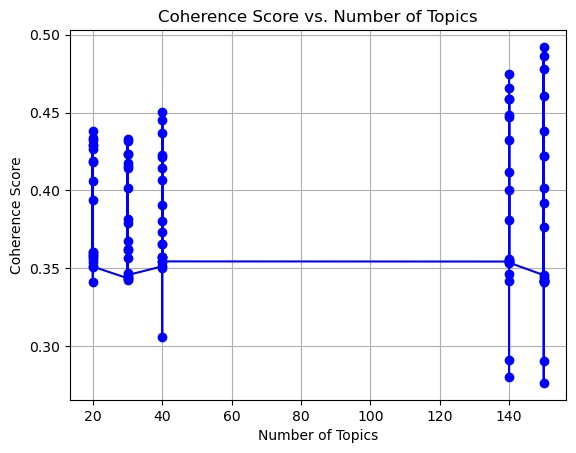

In [ ]:
# Plot coherence scores
plt.plot(sample_lda_tuning['Topics'].to_numpy(), sample_lda_tuning['Coherence'].to_numpy(), 'b-o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()

In [ ]:
max_row_index = sample_lda_tuning['Coherence'].idxmax()
max_row = sample_lda_tuning.loc[max_row_index]
max_row

Topics             150
Alpha        symmetric
Beta              0.81
Coherence     0.492167
Name: 94, dtype: object

In [20]:
best_sample_lda_model = LdaMulticore(corpus=sample_doc_term_matrix,
                   id2word=sample_dictionary,
                   num_topics=150,
                   random_state=100,                  
                   passes=10,
                   alpha=0.31,
                   eta=0.91,
                   workers=num_processors-1)


In [21]:
topics = best_sample_lda_model.print_topics(num_topics=150, num_words=10)
topic_data = []

for topic in topics:
    words = topic[1].split("+")
    topic_words = [word.split("*")[1].strip().replace('"', '') for word in words]
    topic_data.append(topic_words)

df_topics = pd.DataFrame(topic_data, columns=[f"Topic{i}" for i in range(10)])
df_topics.insert(0, "Topic", range(150))


In [44]:
df_topics

,Topic,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,0,ҳлиө,wind,ләел_мқј,ҳл_ҙм,җлҹ,ҳлқҳ,ҳкің,лҙј,ліҙлҙј,нҷ
1,1,arena_analytic,training_sample,distinguished_industry,use,smother,market,zac,deep_convolutional_neural_network,naturally_stop,connect_women
2,2,medical_ai_data_analysis,first_picture,google_parent_company_alphabet,steamtown,performances_take,wednesday_alphabet,widespread_job_cut,knowing_machine,tech_sector_alphabet_cut,engine_publicly
3,3,pmsport,match_feb,wickets_root,ing_car,market,use,ai,company,say,technology
4,4,transaction_review,uses_advance,use,billing_detail,bonifazidenver_co,cofive,ai,datum,say,technology_digit
...,...,...,...,...,...,...,...,...,...,...,...
145,145,wvlt_newsfirst,wayanythe,teamcareerswvlt_paid,alert_weatherfirst_alert_weather,alert_live,dividesupport_local,calendarcontact_usmeet,solutionsmedal,cookingeye,possiblelet_get
146,146,technology_review,alphafold,fox_business,protein,rogd,proteins_found,refinitiv_lipper,million_structure,statement_mutual,market_data_provide
147,147,market,report,santo_cjmorne,invest,call_trading_calls_trade,markets_data_exclusive_trade,thomson_reutersdetail,equity_analysis_actionable_investment,sip_balancerdelay,trackersip_performance
148,148,new_exhibition,world_renowned,rapture,press_preview,content_markete,market,lisbon,complainour_brandsprivacy,bicycle,franca


## Ktrain with Found Optimal n_topics

#### Setting

In [ ]:
import tensorflow as tf

In [ ]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 54.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 50.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 26.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 45.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.37.0-py3-none-any.whl size=25320578 sha256=2266

In [ ]:
import ktrain
from ktrain import text as txt

print('Ktrain Version: ' + ktrain.__version__)

Ktrain Version: 0.37.0


In [ ]:
texts = df_filtered['clean_token'].tolist()

#### 20 topics

In [ ]:
tm_20 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=20, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [ ]:
tm_20.print_topics()

topic 0 | security news privacy military policy cyber cybersecurity threat comment attack
topic 1 | model algorithm used use information using image process time result
topic 2 | google customer content marketing product brand medium business search experience
topic 3 | science research computer university learning scientist researcher course machine project
topic 4 | image video game open best feature app apple window like
topic 5 | energy oil europe gas solution european market patent launch service
topic 6 | human like chatgpt student way work make time people language
topic 7 | chatgpt microsoft openai said google user chatbot model search generative
topic 8 | india news education live indian day world video said watch
topic 9 | star look film say day reveals year black fan time
topic 10 | patient health medical healthcare drug care cancer disease clinical medicine
topic 11 | best car insurance credit vehicle card bank forbes paid real
topic 12 | market report global analysis growt

#### 30 topics

In [ ]:
tm_30 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=30, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [ ]:
tm_30.print_topics()

topic 0 | security news cybersecurity cyber threat attack digital network policy privacy
topic 1 | model algorithm used language training use using human process network
topic 2 | image photo art artist create tool like video work app
topic 3 | science research university course project scientist program student institute engineering
topic 4 | game music world voice time year day player video like
topic 5 | die solution philip und service crypto europe european launch business
topic 6 | energy vehicle robot car autonomous driver driving gas oil tesla
topic 7 | news content comment medium email post facebook social open user
topic 8 | said state city say country year police president national military
topic 9 | star reveals look daughter say black share husband year wife
topic 10 | patient health healthcare medical care cancer drug clinical medicine hospital
topic 11 | china year financial investment bank million billion investor chinese firm
topic 12 | market report analysis global gro

#### 150 topics

In [31]:
tm_150 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=150, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [32]:
tm_150.print_topics()

topic 0 | oil gas price market say stock min inflation rate bank
topic 1 | patient health healthcare medical care hospital clinical imaging disease treatment
topic 2 | google said tech year giant alphabet according week pichai ceo
topic 3 | center contact agent var customer node research request communication field
topic 4 | research project engineering community team said work join access building
topic 5 | updated hour minute prnewsfoto skip news today announced logo weather
topic 6 | cancer breast lunit study screening tissue patient lung clinical image
topic 7 | light eye noise radio station motion zoom mode cool room
topic 8 | camera sensor design module application power product embedded control kit
topic 9 | scott daniel club allen hill suicide thomas colorado delta brown
topic 10 | city traffic transportation road urban location transport map forest download
topic 11 | canada canadian toronto ontario assange donor say montreal urine bell
topic 12 | artificial market report anal

#### Label Useful Results and Save to Local

In [ ]:
import numpy as np

topic_probabilities = tm_20.predict(texts)
topic_ids = np.argmax(topic_probabilities, axis=1)
df_filtered['ktrain_20_topic_id'] = topic_ids

In [ ]:
topic_mapping = {0: "finance", 
                 3: "healthcare", 
                 4: "education", 
                 5: "media", 
                 10: "automative", 
                 14: "entertainment", 
                 19: "company_technology"}

df_filtered['ktrain_topic'] = df_filtered['ktrain_20_topic_id'].map(topic_mapping).fillna("Others")

## BERTopic

In [14]:
# !pip install bertopic

In [22]:
# !pip install --upgrade transformers

In [17]:
# !pip install --upgrade transformers bertopic accelerate

In [25]:
# !pip install --upgrade bertopic transformers accelerate

In [26]:
from bertopic import BERTopic
# from sentence_transformers import SentenceTransformer

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
cannot import name 'PartialState' from 'accelerate' (/opt/conda/lib/python3.10/site-packages/accelerate/__init__.py)

In [ ]:
def remove_stopwords(sentence):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in tokens if not word in stop_words]
    return " ".join(filtered_sentence)

In [ ]:
%%time
df_filtered['clean_text_without_stopwords'] = df_filtered['clean_text'].parallel_apply(remove_stopwords)

#### On Sample

In [ ]:
# first try on sample
df_sample = df_filtered.sample(n=10000)
sample_documents = df_sample['clean_text_without_stopwords'].tolist()  

In [ ]:
# Create a BERTopic model
sample_topic_model_auto = BERTopic(embedding_model="bert-base-nli-mean-tokens",  min_topic_size=50)

In [ ]:
sample_topics, sample_probabilities = sample_topic_model_auto.fit_transform(sample_documents)

In [ ]:
sample_topic_keywords = sample_topic_model_auto.get_topic_info()

In [ ]:
for topic in sample_topic_keywords['Topic'].unique():
    sample_keywords = sample_topic_model_auto.get_topic(topic)
    sample_keywords, _ = zip(*sample_keywords[:5])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} Keywords: {sample_keywords}")

#### On Full Dataset

##### Auto n_topics

In [ ]:
# Create a BERTopic model
topic_model_auto = BERTopic(embedding_model="bert-base-nli-mean-tokens",  min_topic_size=1000)

In [ ]:
%%time
topics_auto, probabilities_tuo = topic_model_auto.fit_transform(df_filtered.clean_text_without_stopwords.tolist())

In [ ]:
topic_keywords_auto = topic_model_auto.get_topic_info()

In [ ]:
for topic in topic_keywords_auto['Topic'].unique():
    keywords_auto = topic_model_auto.get_topic(topic)
    keywords_auto, _ = zip(*keywords_auto[:5])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} Keywords: {keywords_auto}")

##### 20 topics

In [40]:
topic_model_20 = BERTopic(embedding_model="bert-base-nli-mean-tokens", nr_topics=20)

In [41]:
%%time
topics_20, probabilities_20 = topic_model_20.fit_transform(df_filtered.clean_text_without_stopwords.tolist())

CPU times: total: 14h 22min 12s
Wall time: 4h 37min 37s


In [42]:
topic_keywords_20 = topic_model_20.get_topic_info()

In [46]:
for topic in topic_keywords_20['Topic'].unique():
    keywords_20 = topic_model_20.get_topic(topic)
    keywords_20, _ = zip(*keywords_20[:10])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} | {' '.join(keywords_20)}")  # join keywords with space


Topic -1 | ai market the data intelligence new artificial report global also
Topic 0 | market ai the intelligence data artificial new global report analysis
Topic 1 | agriculture market intelligence artificial ai global report growth agricultural analysis
Topic 2 | aviation air flight india market aircraft the intelligence artificial said
Topic 3 | automotive market artificial intelligence report global analysis growth industry key
Topic 4 | bioworld news fox afinancingsnewco nationfox businessfox policy contact gofox shopfox
Topic 5 | coral reef species salmon the fish marine fishing ocean reefs
Topic 6 | recipes food restaurant chef cooking the recipe restaurants ai ingredients
Topic 7 | bard rockies season league beethoven colorado daniel game innings republic
Topic 8 | chess game kasparov human ai the games deepmind humans protein
Topic 9 | sermon chatgpt franklin preaching human sermons congregation church pastor wrote
Topic 10 | banking corporate market ai global report analysis 

##### 25 topics

In [ ]:
topic_model_25 = BERTopic(embedding_model="bert-base-nli-mean-tokens", nr_topics=25)

In [ ]:
topics_25, probabilities_25 = topic_model_25.fit_transform(df_filtered.clean_text_without_stopwords.tolist())

In [ ]:
topic_keywords_25 = topic_model_25.get_topic_info()

In [ ]:
for topic in topic_keywords_25['Topic'].unique():
    keywords_25 = topic_model_25.get_topic(topic)
    keywords_25, _ = zip(*keywords_25[:10])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} Keywords: {keywords_25}")